# Data Preprocessing

## Step1: Import data

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
# from tensorflow.keras import model
from IPython import display
from tqdm import tqdm

from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from custom_layers import MFCC, LogMelSpectrogram
sns.set_context("talk")
# plt.style.use('ggplot')
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-23 18:52:53.840468: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
_SMOKE_SIZE_ = -1

In [3]:
current_task = _TASKS_[0]
current_task

'10kws+U+S'

In [4]:
data_dir = pathlib.Path('data/speech_commands_v0.02')
binaries_dir = pathlib.Path('data/binaries') # here we save training/valid/test set

In [5]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
                                                                     y_train, 
                                                                     X_valid, 
                                                                     y_valid, 
                                                                     X_test, 
                                                                     y_test, 
                                                                     smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['eight', 'follow', 'cat', 'two', 'six', 'sheila', 'four', 'three', 'wow', 'zero', 'marvin', 'happy', 'one', 'dog', 'learn', 'five', 'house', 'visual', 'forward', 'seven', 'bird', 'backward', 'nine', 'tree', 'bed']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']
Samples in Training Set: 98449
Samples in Test Set: 10378
Samples in Validation Set: 11424


From all those keywords, we will teach our models to learn the core 20, and use the remaining ones to help him detect "filler" keywords. So in total, the output classes of our network will be 21.
Indeed, from the readme file:

*Twenty core command words were recorded, with most speakers saying each
of them five times. The core words are "Yes", "No", "Up", "Down", "Left",
"Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
"Five", "Six", "Seven", "Eight", and "Nine". To help distinguish unrecognized
words, there are also ten auxiliary words, which most speakers only said once.
These include "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila",
"Tree", and "Wow".*

**NB**: It seems that there is an error in this readme file, since there are 5 more auxiliary keywords (*'backward', 'follow', 'forward', 'learn', 'visual'*) in the dataset folder!

In [6]:
filenames = get_filenames(data_dir)
print(f"Total number of audio files: {len(filenames)}")

Total number of audio files: 105829


In [7]:
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Samples in Training Set: 98449
Samples in Test Set: 10378
Samples in Validation Set: 11424


In [8]:
w = generate_train_sample(X_train[0])
w = tf.expand_dims(w,0)
w2 = generate_train_sample(X_train[2])
w2 = tf.expand_dims(w2,0)
w3 = tf.concat([w,w2],0)
w3

2021-08-21 18:51:15.310065: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-21 18:51:15.350938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-21 18:51:15.351273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-21 18:51:15.351332: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-21 18:51:15.353455: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 18:51:15.353523: I tensorflow/stream_executor/platf

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.00225724,
         0.00171602,  0.01207108],
       [ 0.        ,  0.        ,  0.        , ..., -0.00114331,
         0.00060964,  0.00184169]], dtype=float32)>

In [9]:
X = MFCC(n_cepstral=40,return_deltas=False)(w3)
X.shape

2021-08-21 18:51:15.969955: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-21 18:51:16.047206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-21 18:51:16.313394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


TensorShape([2, 98, 40, 1])

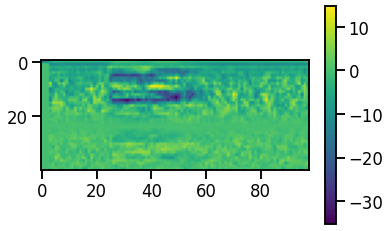

In [10]:
plt.imshow(X[0,:,:,0].numpy().T)
plt.colorbar()
plt.show()

### SpecAugment
from https://arxiv.org/pdf/1904.08779.pdf:

Frequency masking is applied so that $f$ consecutive mel frequency channels $\left[f_{0}, f_{0}+f\right)$ are masked, where $f$ is first chosen from a uniform distribution from 0 to the frequency mask parameter $F$, and $f_{0}$ is chosen from $[0, \nu-f) . \nu$ is the number of mel frequency channels.

Time masking is applied so that $t$ consecutive time steps $\left[t_{0}, t_{0}+t\right)$ are masked, where $t$ is first chosen from a uniform distribution from 0 to the time mask parameter $T$, and $t_{0}$ is chosen from $[0, \tau-t)$.
We introduce an upper bound on the time mask so that a time mask cannot be wider than $p$ times the number of time steps.

In [11]:
b_size = tf.shape(X)[0]
n_features = tf.shape(X)[2]
n_time_steps = tf.shape(X)[1]

print(n_features)
print(n_time_steps)
F = 10
T = 20

f = tf.random.uniform([], minval=0, maxval=F, dtype=tf.int32)
f0 =  tf.random.uniform([], minval=0, maxval=n_features-f, dtype=tf.int32)

t = tf.random.uniform([],minval=0, maxval=T, dtype=tf.int32)
t0 =  tf.random.uniform([],minval=0, maxval=n_time_steps-t, dtype=tf.int32)

print(f'f: {f}; unif from {0} to {F}')
print(f'f0: {f0}; unif from {0} to {n_features-f}')
print(f't: {t}; unif from {0} to {T}')
print(f't0: {t0}; unif from {0} to {n_time_steps-t}')

tf.Tensor(40, shape=(), dtype=int32)
tf.Tensor(98, shape=(), dtype=int32)
f: 6; unif from 0 to 10
f0: 23; unif from 0 to 34
t: 5; unif from 0 to 20
t0: 68; unif from 0 to 93


In [16]:
## time mask
ones1t = tf.ones((n_features, t0-1,1))
print(ones1t.shape)
zerost = tf.zeros((n_features, t,1))
print(zerost.shape)
ones2t = tf.ones((n_features, n_time_steps - t0 -t + 1,1))
print(ones2t.shape)
tmask = tf.concat([ones1t, zerost, ones2t], axis=1)
tmask = tf.transpose(tmask, [1,0,2])
print(tmask.shape)

# plt.imshow(tmask)
# plt.show()
# plt.imshow(fmask)
# plt.show()

(40, 67, 1)
(40, 5, 1)
(40, 26, 1)
(98, 40, 1)


In [ ]:
## frequency mask
ones1f = tf.ones((f0-1, n_time_steps))
print(ones1.shape)
zerosf = tf.zeros((f, n_time_steps))
print(zerosf.shape)
ones2f = tf.ones((n_features - f0 -f + 1, n_time_steps))
print(ones2f.shape)
fmask = tf.concat([ones1f, zerosf, ones2f], axis=0)
fmask = tf.transpose(fmask)
print(fmask.shape)

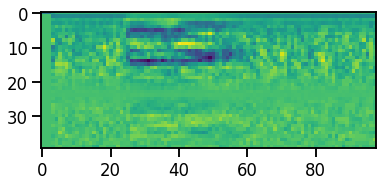

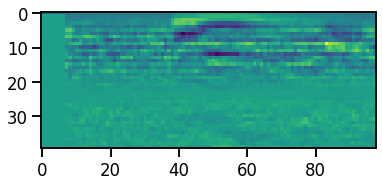

In [28]:
A = SpecAugment(F=14, T=15)(X)
for im in A:
    plt.imshow(im[:,:,0].numpy().T)
    plt.show()

## Comparing energies

In [21]:
# python speech
from python_speech_features.sigproc import preemphasis
highfreq= 8000
signal_emph = preemphasis(signal,0.97)
frames = framesig(signal_emph, 400, 160, lambda x:np.ones((x,)))
pspec = powspec(frames,512)
energy_psf = np.sum(pspec,1) # this stores the total energy in each frame

NameError: name 'signal' is not defined

In [18]:
energy_psf = tf.math.log(energy_psf+1e-6)

NameError: name 'energy_psf' is not defined

In [19]:
# TF
tf_signal = tf.expand_dims(signal,0)
tf_emph = tf.concat([tf_signal[:,0:1], tf_signal[:,1:] - 0.97 * tf_signal[:,:-1]], axis=1)
spectrograms = tf.signal.stft(tf_emph,frame_length=400,
                                      frame_step=160,
                                      fft_length=512)
# get absolute value 
spectrograms = tf.abs(spectrograms)

# for some reason this passage gives a strange result...
#spectrogram=tf.multiply(tf.math.square(spectrogram), 1/_FFT_SIZE)

#compute energy for each frame; energy will be of shape (batch_size, n_frames)
energy = tf.reduce_sum(tf.multiply(tf.math.square(spectrograms), 1/512), axis=2)
energy = tf.expand_dims(energy, -1)
energy_tf = tf.math.log(energy+1e-6)[...,0]

NameError: name 'signal' is not defined

In [20]:
plt.figure(figsize=(20,10))
plt.plot(energy_psf, label="Python Speech Features")
plt.plot(energy_tf[0], label="Tensorflow")
plt.legend()
plt.title("Comparison between energies obtained with python-speech-features library and Tensorflow")
plt.show()

NameError: name 'energy_psf' is not defined

<Figure size 1440x720 with 0 Axes>

### Class balance


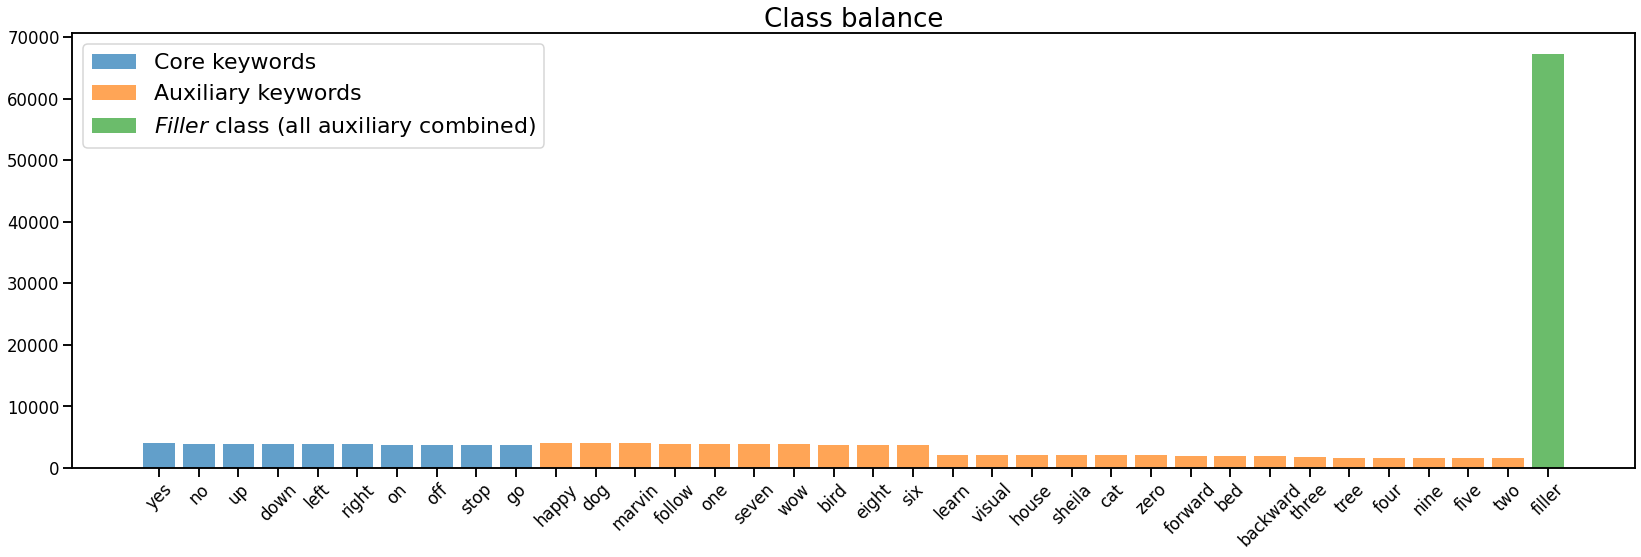

In [7]:
# Let's inspect class balance within the whole dataset
core_samples_amt = []
aux_samples_amt = []
for keyword in core_kws:
    n = len(tf.io.gfile.listdir(data_dir/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    core_samples_amt.append(n)
    
    
for keyword in aux_kws:
    n = len(tf.io.gfile.listdir(data_dir/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    aux_samples_amt.append(n)

plt.figure(figsize=(28,8))
plt.bar(core_kws, np.sort(core_samples_amt)[::-1], label="Core keywords", alpha=0.7)
plt.bar(aux_kws, np.sort(aux_samples_amt)[::-1], label="Auxiliary keywords", alpha=0.7)
plt.bar("filler", sum(np.sort(aux_samples_amt)[::-1]), label="$Filler$ class (all auxiliary combined)", alpha=0.7)
plt.legend(fontsize=22)
plt.xticks(rotation=45)
plt.title("Class balance", fontsize=26)
plt.show()

We can see that classes are more or less balanced within core words and within auxiliary words; however, we will combine all the auxiliary words into a single class "filler", therefore such class will be unbalanced with respect to the others.

In [8]:
#visualize class balance
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
unique_te, counts_te = np.unique(y_test, return_counts=True)

In [9]:
unique_tr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

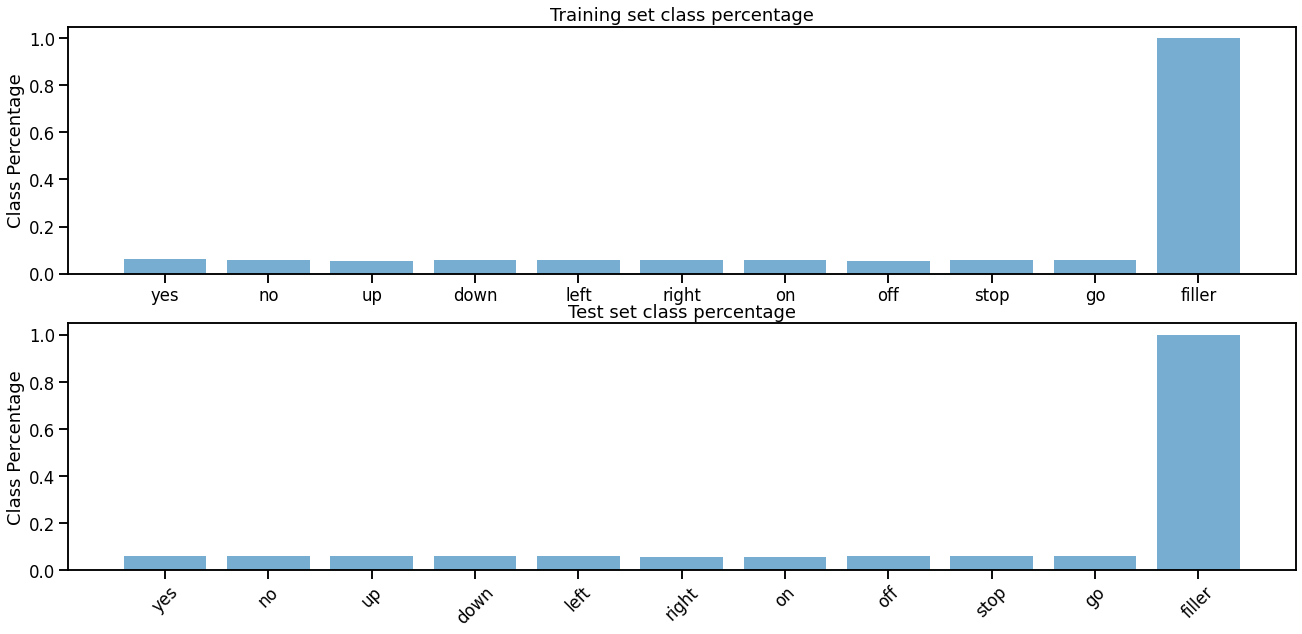

In [10]:
#display same class balance
fig, axes = plt.subplots(2, figsize=(22,10))
axes[0].bar([output_classes[i] for i in  unique_tr], counts_tr/max(counts_tr), alpha=0.6)
axes[1].bar([output_classes[i] for i in  unique_te], counts_te/max(counts_te), alpha=0.6)
axes[0].set_ylabel("Class Percentage")
axes[1].set_ylabel("Class Percentage")
axes[0].set_title("Training set class percentage")
axes[1].set_title("Test set class percentage")
plt.xticks(rotation=45)
plt.show()

## List of preprocessing steps.
We now have a dataset (already split in train, validation and test) which is just a collection of filenames, and their related collection of ground truth labels. We now have to load the actual data. To do that, we define speific functions that for each audio file name produce the actual input features for the NN.
Those are the preprocessing steps, which are as follows:

1) From the file, load the actual sound waveform. It is a time series data normalized in the range [-1,1], and almost all are composed of 16000 samples. Since the sounds' sample rate is 16kHz, they are almost all audio clips of 1 second. We don't need to make zero padding since the actual input for the NN will be crops of fixed size of the feature vectors.

Note that this is the only true Preprocessing step that we will make to our dataset. All the following steps will be implemented as custom layers which will be part of our NN models. This choice was made for several reasons: first, the dataset is too big to fit into the memory of my GPU, so the only choice was to create an efficient input pipeline with a `tf.data.Dataset`, configured to load chunks of data during training (with `dataset.prefetch()`) and using caching (with `dataset.cache()`) to speed things ever more. Even doing so, all the following preprocessing steps were really expensive for the CPU which, at training time, was causing a significant bottleneck. For this reasons, I implemented the following preprocessing steps as custom NN layers, in order to make parallel computations for each batch and eliminating the CPU bottleneck.

2) Create audio frames of $w$ samples, with step size $s$, and for each of them extract the Mel Frequency Cepstral Coefficients from the audio files. This creates a feature vector of dimension $39$ for each audio frame. Main hyperparameters for this step are window length and window step. Additional experiments can be made with different n. of filters.

3) Normalization of features ... (metto direttamente la batch normalization?)

4) Since the actual input for the CNN is a stacking of more frames (which we call **atom** for semplcity) we need to extract atoms from the full FMCC spectrum of each clip (which is a matrix). An atom is created from a frame by stacking $p$ frames of past context and $f$ frames of future context with the current frame. This simply consists of generating a cropping along the time axis of such matrix, since atoms are shorter than $1$ second. We can crop randomly each time a sample is used for training. For validation and testing instead, we need to use always the same dataset, and we crop in the middle of the file.

## 1. Get audio wave from file

Note: The sample rate in this dataset is 16kHz.
We use `tf.audio.decode_wav` to decode the wav binary files into time series data normalized in the range [-1,1].
Specifically:

 - `tf.io.read_file(file_path)`: reads the .wav file and stores it as a binary array;
 - `tf.audio.decode_wave(binary)`: reads the binary file and converts it in a time series of audio samples.

2021-08-17 00:29:51.637607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-17 00:29:51.669580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-17 00:29:51.669917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-17 00:29:51.669950: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-17 00:29:51.676719: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-17 00:29:51.676842: I tensorflow/stream_executor/platf

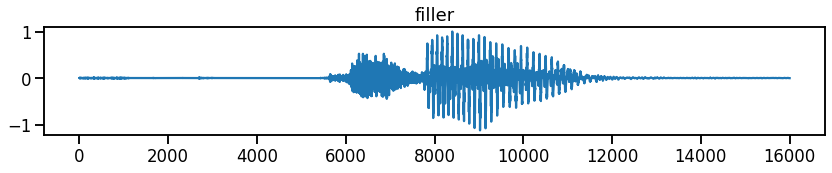

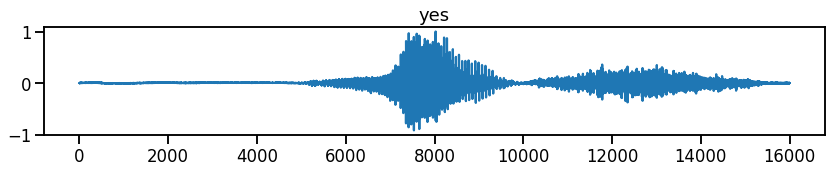

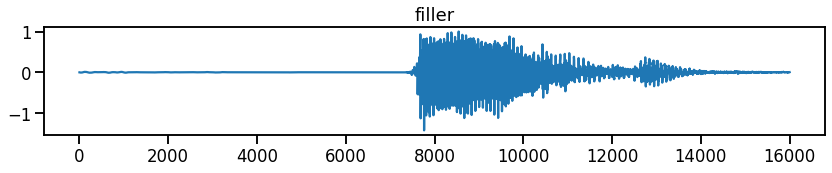

In [11]:
#Display and listen to some of the waveforms
for s in X_train[:3]:
    _ = plt.figure(figsize=(14,2))
    plt.plot(decode_audio(s))
    plt.title(output_classes[get_label_int(s)])
    plt.show()
    # We can also preview the sound
    display.display(display.Audio(decode_audio(s), rate=16000))

## Mix and Add noise samples
We also want our network to recognize silence, other than target keywords and unknown keywords.

Also we have to randomly add this noise to the training samples 

From:https://arxiv.org/pdf/2010.09960.pdf: 
Following Google's preprocessing procedure, we randomly add background noise, multiplied with a random coefficient sampled from uniform distribution $U(0,0.1)$, to training samples with a probability of $0.8$. 

possible idea: We also perform a random $Y$ ms time shift to the audio files, where $Y$ is samples from $U(-100,100) .$




In [12]:
noise_samples_names = get_noise_samples_names()

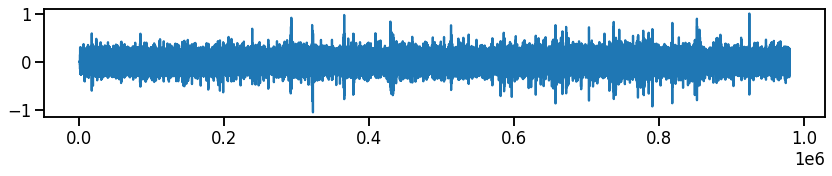

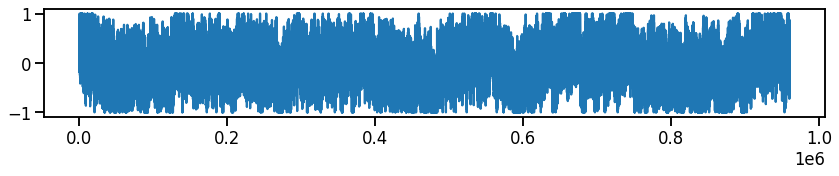

In [13]:
for s in noise_samples_names[:2]:
    _ = plt.figure(figsize=(14,2))
    plt.plot(decode_audio(s, zero_pad=False))
    plt.show()
    # We can also preview the sound
    display.display(display.Audio(decode_audio(s, zero_pad=False), rate=16000))

These noise files are long and of different lengths. We have to pick one second long random crops from them.

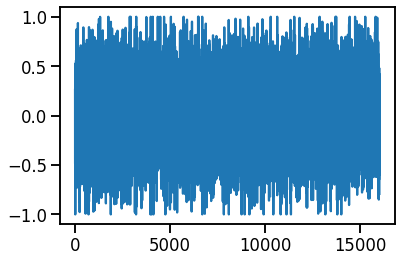

In [14]:
ex = generate_noise_crop()
plt.plot(ex)
plt.show()
display.display(display.Audio(ex, rate=16000))

Now we can add this noise to any train/valid/test sample to make the model more robust to background noise. We also ask to take a random crop of width `_CROP_WIDTH_`

In [15]:
input_pipeline._CROP_WIDTH_

-1

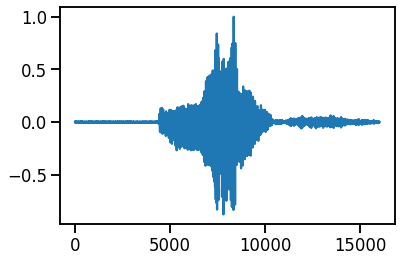

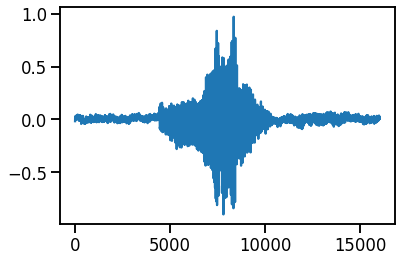

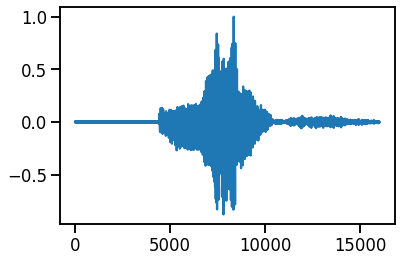

In [16]:
#Some examples of noisy samples
for i in range(3):
    ex = generate_sample(filenames[0])
    plt.plot(ex)
    plt.show()
    # We can also preview the sound
    display.display(display.Audio(ex, rate=16000))

In [17]:
# ADD noise samples to train, valid and test set, with the same proportion of unknown words.
unkn_i = output_classes.index(input_pipeline._UNKNOWN_CLASS_)
sil_i = output_classes.index(input_pipeline._SILENCE_CLASS_)
n_sil_train = len(y_train[y_train==unkn_i])
n_sil_valid = len(y_valid[y_valid==unkn_i])
n_sil_test = len(y_test[y_test==unkn_i])

X_train, y_train, X_valid, y_valid, X_test, y_test = add_silence_samples(X_train, 
                                                                         y_train, 
                                                                         X_valid, 
                                                                         y_valid, 
                                                                         X_test, 
                                                                         y_test,
                                                                        n_sil_train//4,
                                                                        n_sil_valid//4,
                                                                        n_sil_test//4)

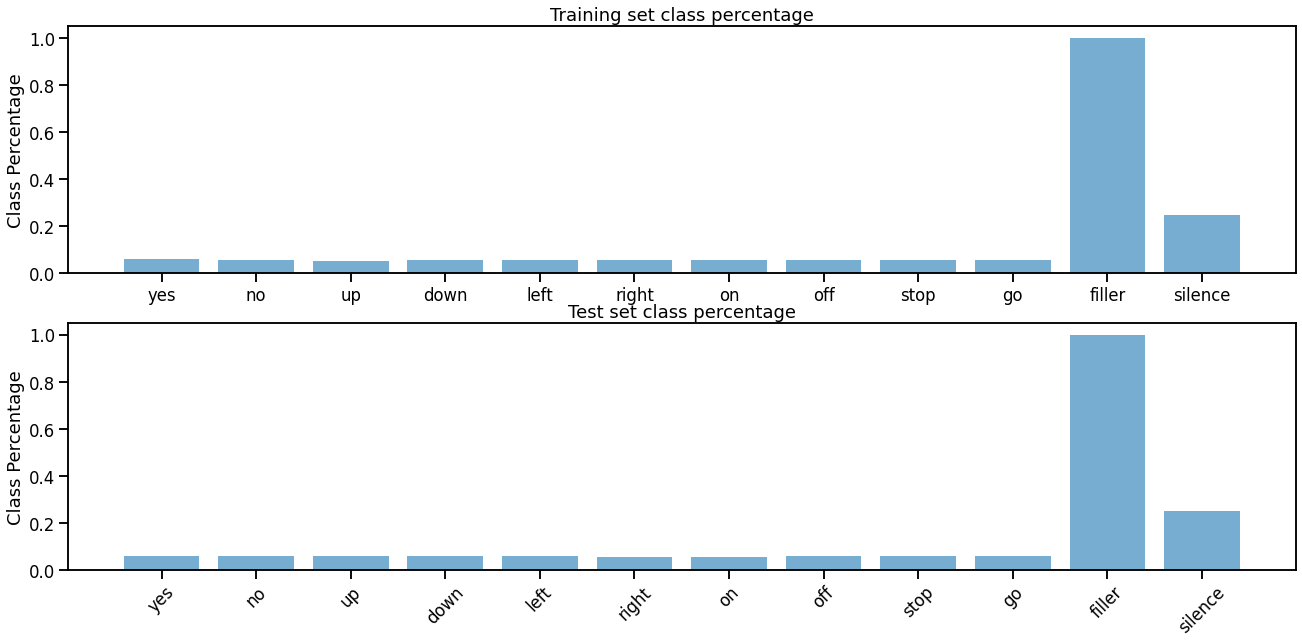

In [80]:
unique_tr, counts_tr = np.unique(y_train, return_counts=True)
unique_te, counts_te = np.unique(y_test, return_counts=True)
fig, axes = plt.subplots(2, figsize=(22,10))
axes[0].bar([output_classes[i] for i in  unique_tr], counts_tr/max(counts_tr), alpha=0.6)
axes[1].bar([output_classes[i] for i in  unique_te], counts_te/max(counts_te), alpha=0.6)
axes[0].set_ylabel("Class Percentage")
axes[1].set_ylabel("Class Percentage")
axes[0].set_title("Training set class percentage")
axes[1].set_title("Test set class percentage")
plt.xticks(rotation=45)
plt.show()

## Create tf.Dataset of waveforms

In [23]:
# TEST DATASET E MODEL
batch_size = 128

smoke_size = 0

if smoke_size > 0:
    names_train = X_train[:smoke_size]
    labels_train = y_train[:smoke_size]
    names_valid = X_valid[:int(smoke_size/10)]
    labels_valid = y_valid[:int(smoke_size/10)]
else:
    names_train = X_train
    labels_train = y_train
    names_valid = X_valid
    labels_valid = y_valid
    names_test = X_test
    labels_test= y_test
    

train_dataset = create_dataset(names_train,
                               labels_train, 
                               batch_size=batch_size, 
                               shuffle=False)

valid_dataset = create_dataset(names_valid,
                             labels_valid,
                             batch_size=batch_size, 
                             shuffle=False)

test_dataset = create_dataset(names_test,
                             labels_test,
                             batch_size=batch_size, 
                             shuffle=False)

train_steps = int(np.ceil(len(names_train)/batch_size))
valid_steps = int(np.ceil(len(names_valid)/batch_size))
test_steps = int(np.ceil(len(names_test)/batch_size))
print(f"Train steps: {train_steps}")
print(f"Validations steps: {valid_steps}")
print(f"Test steps: {test_steps}")


for i in train_dataset.take(1):
    print("Example of dataset element:")
    print(i)

Train steps: 1213
Validations steps: 128
Test steps: 141
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[-3.4272286e-01,  4.3894771e-01, -2.3749503e-01, ...,
        -1.7908262e-01, -3.4556109e-01, -6.9399089e-02],
       [ 1.0544145e-01, -9.7415082e-02,  2.0404676e-01, ...,
         5.2134770e-01,  2.8342539e-01,  1.9806514e-02],
       [-2.2885783e-02,  1.5516285e-02,  2.9583680e-02, ...,
         1.0634679e-02, -4.6672300e-05, -3.1399215e-03],
       ...,
       [ 2.6142156e-01,  9.8007143e-01,  6.0905790e-01, ...,
         1.8860439e-02,  2.7756584e-01,  2.9905087e-01],
       [ 2.4811372e-02,  7.2595612e-03, -6.0314673e-04, ...,
        -1.6693544e-02, -5.2694261e-02, -3.7268616e-02],
       [-6.3482180e-02, -1.1107990e-01, -6.1695829e-02, ...,
         3.4071445e-03, -3.5983711e-03, -1.0230627e-02]], dtype=float32)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([11, 11,  9, 11, 11, 10, 11, 11, 10, 10, 11, 10,  6, 11, 10, 10, 10,
 

2021-08-17 00:29:54.781666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-17 00:29:54.805701: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


## Extraction of cepstral coefficients

TODO: to review... we explain here how to compute MFCCs.
How many frames are created from a wave?
Assume we use 25ms windows, distantiated by 10ms. We are using a sample rate of 16kHz, therefore 25ms are 400 samples, and 10ms are 160 samples. We keep framing until the end of the speech signal. 

If $n$ is the total number of samples, $w$ is the frame width and $s$ is the time step, then the total number of obtained frames is:

$$x = \frac{n-w}{s}+1 $$

If that fraction isnt a natural number, we zero pad the signal (automatically done by the library).

In [9]:
import librosa.display
import librosa as lr

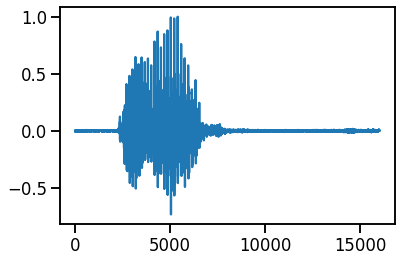

In [10]:
test_wave = decode_audio(X_train[1011])
plt.plot(test_wave)
plt.show()

In [11]:
test_waves = tf.stack([decode_audio(X_train[1010]), decode_audio(X_train[1011])])

In [12]:
test_waves

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[ 0.00200927,  0.00417311,  0.00556414, ...,  0.0072643 ,
         0.00417311,  0.00255023],
       [ 0.00076593, -0.00265523, -0.0014808 , ...,  0.00505515,
         0.00158292,  0.00076593]], dtype=float32)>

In [13]:
_SAMPLE_RATE = 16000
_FFT_SIZE = 512 #determines the number of frequency bins (which is fft_size/2 + 1)
_FRAME_SIZE = 400 #frame length: this value determines the tradeoff between time vs frequency resolution
_HOP_SIZE = 160 #hop size
_N_MEL_BINS = 26 #numero di filtri
_N_SPECTROGRAM_BINS = (_FFT_SIZE // 2) + 1
_F_MIN = 0.0
_F_MAX = _SAMPLE_RATE / 2

In [21]:
spectrogram = tf.signal.stft(test_wave, 
                              frame_length=_FRAME_SIZE, 
                              frame_step=_HOP_SIZE)
spectrogram =  tf.abs(spectrogram)
# spectrogram=tf.multiply(tf.math.square(spectrogram), 1/_FFT_SIZE)
spectrogram = tf.expand_dims(spectrogram, 0)
spectrogram

<tf.Tensor: shape=(1, 98, 257), dtype=float32, numpy=
array([[[0.02008221, 0.02622479, 0.05076142, ..., 0.00140861,
         0.00201852, 0.00215237],
        [0.02408672, 0.02989651, 0.01720685, ..., 0.00084567,
         0.00167872, 0.00214377],
        [0.00396796, 0.01732219, 0.04205692, ..., 0.00081695,
         0.00092263, 0.00051097],
        ...,
        [0.15851721, 0.22663614, 0.29418144, ..., 0.00116507,
         0.0008659 , 0.00065076],
        [0.08448893, 0.2562118 , 0.46666908, ..., 0.00180757,
         0.00176009, 0.00138088],
        [0.08039869, 0.24053748, 0.39280614, ..., 0.00237232,
         0.00167579, 0.00108949]]], dtype=float32)>

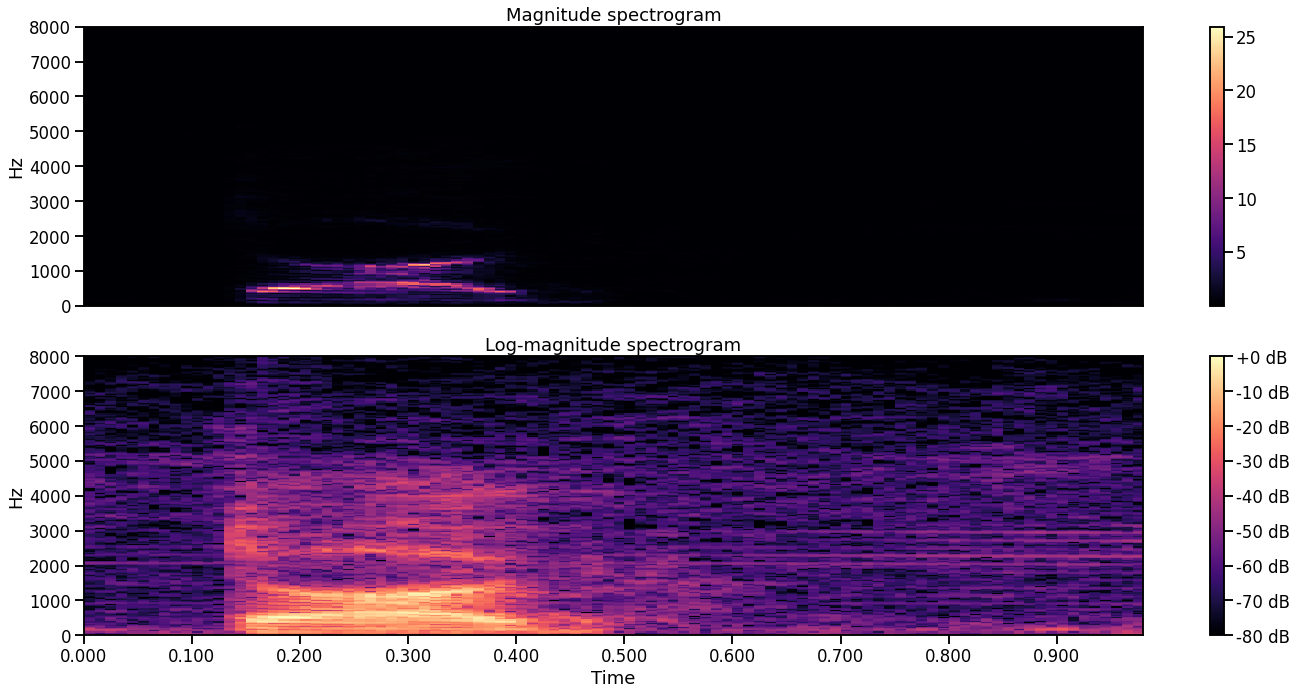

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
lr.display.specshow(spectrogram[0].numpy().T, sr=_SAMPLE_RATE, y_axis='linear')
plt.colorbar()
plt.title('Magnitude spectrogram')

plt.subplot(2, 1, 2)
lr.display.specshow(lr.amplitude_to_db(spectrogram[0].numpy().T, ref=np.max),
                    y_axis='linear', x_axis='time', sr=_SAMPLE_RATE, 
                    hop_length=_HOP_SIZE)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-magnitude spectrogram')
plt.tight_layout()
# _ = plt.savefig('magspec.png', dpi=300)

In [25]:
pspectrogram=tf.multiply(tf.math.square(spectrogram), 1./_FFT_SIZE)
pspectrogram

<tf.Tensor: shape=(1, 98, 257), dtype=float32, numpy=
array([[[7.87686247e-07, 1.34324159e-06, 5.03265892e-06, ...,
         3.87533028e-09, 7.95785304e-09, 9.04823771e-09],
        [1.13314479e-06, 1.74570516e-06, 5.78272534e-07, ...,
         1.39680012e-09, 5.50410917e-09, 8.97607766e-09],
        [3.07513126e-08, 5.86051044e-07, 3.45465764e-06, ...,
         1.30351796e-09, 1.66260339e-09, 5.09946030e-10],
        ...,
        [4.90775528e-05, 1.00320198e-04, 1.69028746e-04, ...,
         2.65112954e-09, 1.46442569e-09, 8.27135027e-10],
        [1.39421463e-05, 1.28211876e-04, 4.25351638e-04, ...,
         6.38144515e-09, 6.05061246e-09, 3.72427356e-09],
        [1.26248997e-05, 1.13004455e-04, 3.01360677e-04, ...,
         1.09920117e-08, 5.48488632e-09, 2.31834085e-09]]], dtype=float32)>

In [26]:
energy = tf.reduce_sum(pspectrogram, axis=2)

In [27]:
energy

<tf.Tensor: shape=(1, 98), dtype=float32, numpy=
array([[1.0302895e-03, 5.9814414e-04, 7.5575768e-04, 5.7152472e-04,
        3.1245968e-04, 2.9510894e-04, 2.9211040e-04, 5.0561607e-04,
        4.7214419e-04, 4.5597731e-04, 2.8936297e-04, 3.6282942e-04,
        4.7202021e-04, 2.0038020e-02, 1.0214033e-01, 1.1598914e+00,
        2.5361304e+00, 3.8109946e+00, 3.7030892e+00, 3.8339772e+00,
        3.0811019e+00, 2.5949619e+00, 2.2365136e+00, 2.1199889e+00,
        1.5413108e+00, 3.2013080e+00, 4.0151052e+00, 3.1834440e+00,
        3.8947761e+00, 4.6143236e+00, 5.1828542e+00, 4.8915038e+00,
        4.3999500e+00, 3.4908524e+00, 3.2410305e+00, 2.8220706e+00,
        2.8200636e+00, 2.0695314e+00, 1.6341920e+00, 1.0408690e+00,
        3.5965651e-01, 1.0612065e-01, 5.2279368e-02, 3.6976017e-02,
        4.2306624e-02, 4.3137677e-02, 5.1456887e-02, 2.0756889e-02,
        6.2897271e-03, 2.3721131e-03, 2.5632461e-03, 1.5401894e-03,
        1.5896740e-03, 1.9695479e-03, 1.8424138e-03, 1.4049353e-03,

We now convert the spectrogram from hertz to mel scale. The mapping is done by `tf.signal.linear_to_mel_weight_matrix()` function, which defines the mel scale according to the following formula:

$$ \operatorname{mel}(f)=2595 * \log _{10}\left(1+\frac{f}{700}\right) $$

In [28]:
# Warp the linear scale spectrograms into the mel-scale.
# spectrogram=tf.multiply(tf.math.square(spectrogram), 1.0/_FFT_SIZE)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=_N_MEL_BINS,
    num_spectrogram_bins=_N_SPECTROGRAM_BINS,
    sample_rate=_SAMPLE_RATE,
    lower_edge_hertz=_F_MIN,
    upper_edge_hertz=_F_MAX)
print(linear_to_mel_weight_matrix.shape)

(257, 26)


In [29]:
mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
# mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(
#   linear_to_mel_weight_matrix.shape[-1:]))

2021-08-18 16:08:14.139547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-18 16:08:15.209701: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [30]:
mel_spectrograms
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
log_mel_spectrograms

<tf.Tensor: shape=(1, 98, 26), dtype=float32, numpy=
array([[[-1.6697707 , -0.25709856, -0.7085594 , ..., -1.5899297 ,
         -2.0147202 , -2.6889968 ],
        [-1.8311194 , -0.55870783, -1.3557082 , ..., -1.7993106 ,
         -1.9182425 , -2.3686767 ],
        [-1.433445  , -0.399706  , -1.6933932 , ..., -1.8240209 ,
         -1.9654008 , -2.342658  ],
        ...,
        [-0.52918875, -0.55287766, -0.7909642 , ..., -1.5255284 ,
         -1.8827468 , -2.549266  ],
        [-0.0933751 , -0.3574412 , -0.66002715, ..., -1.936029  ,
         -2.3811495 , -2.4710672 ],
        [-0.3718412 , -0.7361946 , -1.4327661 , ..., -2.173679  ,
         -1.9877424 , -1.9877521 ]]], dtype=float32)>

In [32]:
tf.concat([tf.expand_dims(energy, -1), log_mel_spectrograms ], axis=2)

<tf.Tensor: shape=(1, 98, 27), dtype=float32, numpy=
array([[[ 1.0302895e-03, -1.6697707e+00, -2.5709856e-01, ...,
         -1.5899297e+00, -2.0147202e+00, -2.6889968e+00],
        [ 5.9814414e-04, -1.8311194e+00, -5.5870783e-01, ...,
         -1.7993106e+00, -1.9182425e+00, -2.3686767e+00],
        [ 7.5575768e-04, -1.4334450e+00, -3.9970601e-01, ...,
         -1.8240209e+00, -1.9654008e+00, -2.3426580e+00],
        ...,
        [ 1.4060830e-03, -5.2918875e-01, -5.5287766e-01, ...,
         -1.5255284e+00, -1.8827468e+00, -2.5492661e+00],
        [ 2.2000158e-03, -9.3375102e-02, -3.5744119e-01, ...,
         -1.9360290e+00, -2.3811495e+00, -2.4710672e+00],
        [ 1.5962245e-03, -3.7184119e-01, -7.3619461e-01, ...,
         -2.1736791e+00, -1.9877424e+00, -1.9877521e+00]]], dtype=float32)>

In [ ]:
#NOW compute MFCCs from log-magnitude mel scaled spectrogram
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)
mfccs = mfccs[:,:13]
mfccs

LIFTERING
https://dsp.stackexchange.com/questions/63505/understanding-liftering-as-the-final-step-in-mfccs-features-extraction

https://maxwell.ict.griffith.edu.au/spl/publications/papers/euro99_kkp_fbe.pdf

lifter source code: https://github.com/jameslyons/python_speech_features/blob/e280ac2b5797a3445c34820b0110885cd6609e5f/python_speech_features/base.py#L179

In [ ]:
from python_speech_features import lifter

In [ ]:
def tf_lift(mfccs, L=22):
    n = tf.range(mfccs.shape[1], dtype=tf.float32)
    lift = 1.0 + (L/2.0)*tf.math.sin(np.pi*n/L)
    print(mfccs.shape, lift.shape)
    return mfccs * lift

In [ ]:
plt.figure(figsize=(14,10))
n_mfccs = tf_lift(mfccs, 30)
plt.imshow(n_mfccs.numpy().T)
print(mfccs.shape)
# plt.colorbar()
plt.show()

Produces very similar result to the python_speech_features library..

In [ ]:
cc = mfcc(decode_audio(X_train[1011]), samplerate=_SAMPLE_RATE, winlen=0.025, winstep=0.01, numcep=13, nfilt=_N_MEL_BINS, lowfreq=_F_MIN, highfreq=_F_MAX)
plt.figure(figsize=(14,10))
print(cc.shape)
plt.imshow(cc.T)
# plt.colorbar()
plt.show()

## MFCC custom layer and LogMelSpectrogram custom layer

In [ ]:
layer0 = MelSpectrogram(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26)

In [ ]:
log_mel_sp = layer0(tf.expand_dims(decode_audio(X_train[0]), 0))

In [ ]:
layer = MFCC(sample_rate = 16000, fft_size=512, win_size=400, hop_size=160, n_filters=26, n_cepstral=13)

In [ ]:
layer(tf.expand_dims(decode_audio(X_train[0]), 0))